#WORKSHOP_001 - Python Data Engineer
###Xilena A. Rojas Salazar

###Step 1.- Import modules and create the conection to the DB

In [125]:
#  ###Before import modules, if you didn´t have them, install:###
# !pip install sqlalchemy
# !pip install pandas
# !pip install mysqlclient
# !pip install prettytable
from sqlalchemy import create_engine as ce
from sqlalchemy import Column, String, Integer, Date, func, and_, extract
from sqlalchemy.orm import sessionmaker, declarative_base
from prettytable import PrettyTable
import pandas as pd
import matplotlib.pyplot as plt
import MySQLdb
import csv
import json


**NOTE:  **
To establish the connection to the database, it´s necessary to have a file named "config_db.json" containing your database credentials in json format. This file should include the following key-value pairs: "localhost" for the server address, "user" for the username, "password" for the password, and "database" for the specific database you intend to access. Each key should be assigned its corresponding credential value.

In [6]:
with open('config_db.json') as config_json:
    config = json.load(config_json)

mysql_engine= ce(f"mysql://{config['user']}:{config['password']}@{config['host']}/{config['database']}")

###Step 2.- Create table

**NOTE:  **
About "Base": Classes that inherit from Base become models that represent tables, but are primarily used to define the database structure, not to directly interact with data. That´s why I´m using it to create the table in my db.

In [8]:
Base= declarative_base()


class Table(Base):
    __tablename__ = 'candidates'
    id = Column('id', Integer, primary_key=True, autoincrement= True)
    first_name = Column('first_name', String(20))
    last_name  = Column ('last_name',String (20))
    email = Column('email',String(50))
    application_date = Column('application_date', Date)
    country = Column('country', String(60))
    yoe = Column('yoe', Integer) #This means Years Of Experience
    seniority = Column('seniority', String(15))
    technology = Column('technology', String(50))
    code_challenge_Score = Column('code_challenge_Score', Integer)
    technical_intrvw_score = Column('technical_intrvw_score', Integer)

Base.metadata.create_all(mysql_engine)

**NOTE:  **
You can check the db to see if your table was created correctly.
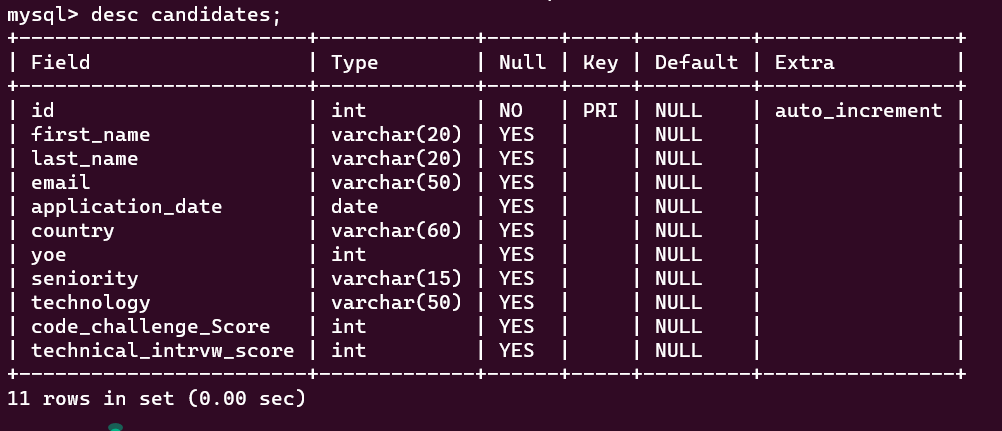

###Step 3.- Load the data to the db from a csv file

**NOTE:  **
About "Session" and "session": This creates a session, just as the names tell us, that help to interact with the data (insert, delete, modify). 

In [9]:
Session = sessionmaker(bind=mysql_engine)
session = Session()

file = "candidates.csv"
data = pd.read_csv(file, sep=";")
#print(data)

count_db = session.query(func.count()).select_from(Table).scalar()
data_in_db = count_db > 0
# print(count)
# print(data_in_db)

if not data_in_db:
    for _, i in data.iterrows():
        record = Table(
            first_name=i['first_name'],
            last_name=i['last_name'],
            email=i['email'],
            application_date=i['application_date'],
            country=i['country'],
            yoe=i['yoe'],
            seniority=i['seniority'],
            technology=i['technology'],
            code_challenge_Score=i['code_challenge_Score'],
            technical_intrvw_score=i['technical_intrvw_score']
        )
        session.add(record)


    session.commit()
session.close()



###Step 4.- Chart visualization and analysis

**NOTE: ** A candidate is considered hired if he/she has both scores greater than or equal to 7.

1. Hires by technology (pie chart)

+-----------------------------------------+-------------+
|                Technology               | Hires Count |
+-----------------------------------------+-------------+
|             Game Development            |     519     |
|                  DevOps                 |     495     |
|          System Administration          |     293     |
|        Development - CMS Backend        |     284     |
|         Adobe Experience Manager        |     282     |
|         Database Administration         |     282     |
|              Client Success             |     271     |
|                 Security                |     266     |
|          Development - Frontend         |     266     |
|                 Mulesoft                |     260     |
|                QA Manual                |     259     |
|                Salesforce               |     256     |
| Business Analytics / Project Management |     255     |
|              Data Engineer              |     255     |
|          Dev

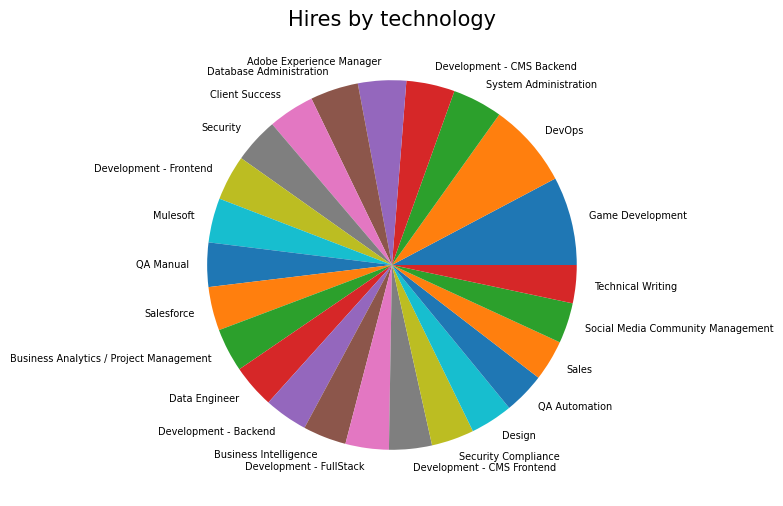

In [122]:
Session = sessionmaker(bind=mysql_engine)
session = Session()

groupby_tech = session.query(Table.technology, func.count(Table.technology)).filter(and_(Table.code_challenge_Score >= 7, Table.technical_intrvw_score >= 7)).group_by(Table.technology).order_by(func.count(Table.technology).desc()).all() 
# print(groupby_tech)

session.close()

result = PrettyTable()
result.field_names = ["Technology", "Hires Count"]
for technology, hires_count in groupby_tech:
    result.add_row([technology, hires_count])
print(result)

technology = [tech for tech, _ in groupby_tech]
count = [count for _,count in groupby_tech]
# print(technology)
# print(count)
fig = plt.figure(figsize =(8, 6))
plt.pie(count, labels = technology)
plt.rcParams['font.size'] = 7
plt.title("Hires by technology", fontsize=15)
plt.show()

session.close()


2. Hires by year (horizontal bar chart)

+------+-------------+
| Year | Hires Count |
+------+-------------+
| 2018 |     1409    |
| 2019 |     1524    |
| 2020 |     1485    |
| 2021 |     1485    |
| 2022 |     795     |
+------+-------------+


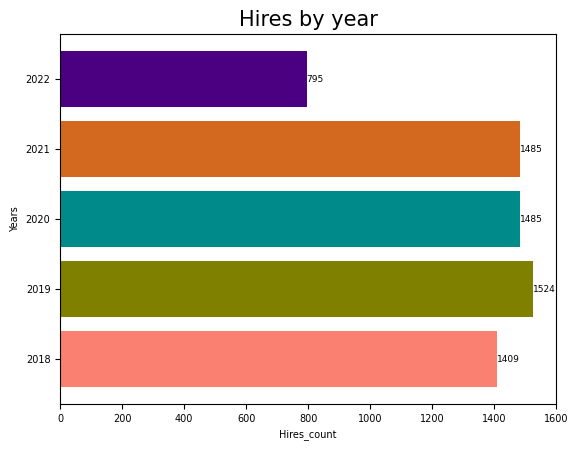

In [151]:
Session = sessionmaker(bind=mysql_engine)
session = Session()

groupby_year= session.query(func.extract('year', Table.application_date), func.count(Table.application_date)).filter(and_(Table.code_challenge_Score >= 7, Table.technical_intrvw_score >= 7)).group_by(func.extract('year', Table.application_date)).order_by(func.extract('year', Table.application_date)).all()
# print (groupby_year)

session.close()

result2 = PrettyTable()
result2.field_names = ["Year", "Hires Count"]

###These lists will help me for the chart.###
years_list = []
hires_count_list = []

for year, hires_count in groupby_year:
    result2.add_row([year, hires_count])
    years_list.append(year)
    hires_count_list.append(hires_count)
print(result2)
# print(years_list)
# print(hires_count_list)

colors = ['salmon', 'olive', 'darkcyan', 'chocolate', 'indigo']
bars=plt.barh(years_list, hires_count_list, color = colors)
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
             f'{bar.get_width():.0f}',
             va='center', fontsize=6.5, color='black')
plt.ylabel("Years")
plt.xlabel("Hires_count")
plt.title("Hires by year", fontsize=15)
plt.show()

3. Hires by seniority (bar chart)

+-----------+-------------+
| Seniority | Hires Count |
+-----------+-------------+
|   Intern  |     985     |
|   Junior  |     977     |
|  Trainee  |     973     |
| Architect |     971     |
|   Senior  |     939     |
|    Lead   |     929     |
| Mid-Level |     924     |
+-----------+-------------+


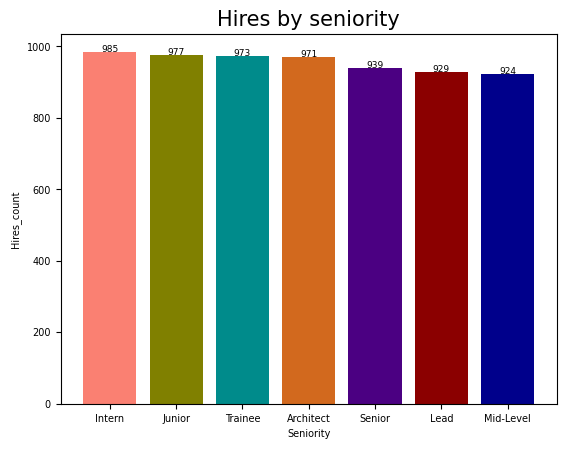

In [190]:
Session = sessionmaker(bind=mysql_engine)
session = Session()

groupby_seniority= session.query(Table.seniority, func.count(Table.seniority)).filter(and_(Table.code_challenge_Score >= 7, Table.technical_intrvw_score >= 7)).group_by(Table.seniority).order_by(func.count(Table.seniority).desc()).all() 
# print (groupby_seniority)

session.close()

result3 = PrettyTable()
result3.field_names = ["Seniority", "Hires Count"]

###These lists will help me for the chart.###
seniority_list = []
hires_count_list = []

for senior, hires_count in groupby_seniority:
    result3.add_row([senior, hires_count])
    seniority_list.append(senior)
    hires_count_list.append(hires_count)
print(result3)
# print(seniority_list)
# print(hires_count_list)

colors = ['salmon', 'olive', 'darkcyan', 'chocolate', 'indigo', 'darkred', 'darkblue']
bars=plt.bar(seniority_list, hires_count_list, color = colors)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
             f'{bar.get_height():.0f}',
             ha='center', fontsize=6.5, color='black')
plt.ylabel("Hires_count")
plt.xlabel("Seniority")
plt.title("Hires by seniority", fontsize=15)
plt.show()



In [ ]:
4. Hires by country over years (USA, Brazil, Colombia, and Ecuador only)(multiline chart)

+------+--------------------------+-------------+
| Year |         Country          | Hires Count |
+------+--------------------------+-------------+
| 2018 |          Brazil          |      9      |
| 2018 |         Colombia         |      7      |
| 2018 |         Ecuador          |      1      |
| 2018 | United States of America |      5      |
| 2019 |          Brazil          |      7      |
| 2019 |         Colombia         |      8      |
| 2019 |         Ecuador          |      3      |
| 2019 | United States of America |      3      |
| 2020 |          Brazil          |      6      |
| 2020 |         Colombia         |      8      |
| 2020 |         Ecuador          |      8      |
| 2020 | United States of America |      4      |
| 2021 |          Brazil          |      7      |
| 2021 |         Colombia         |      1      |
| 2021 |         Ecuador          |      5      |
| 2021 | United States of America |      8      |
| 2022 |          Brazil          |      4      |


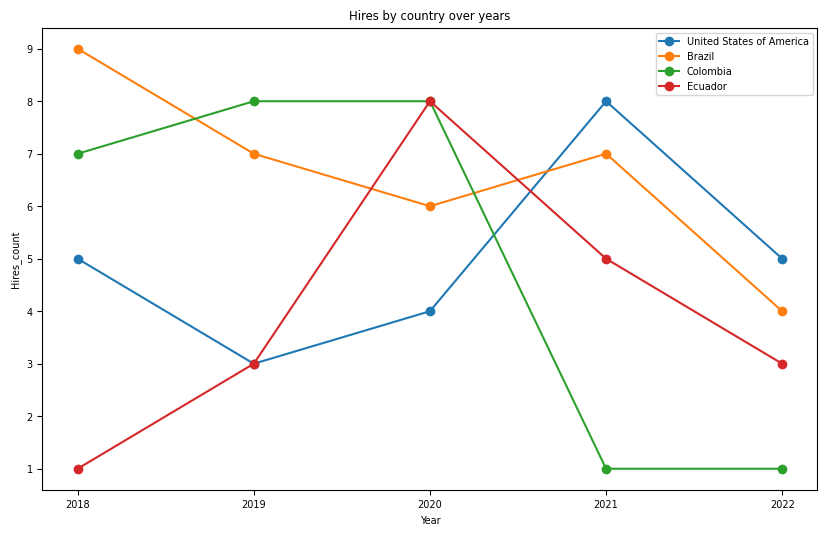

In [239]:
Session = sessionmaker(bind=mysql_engine)
session = Session()


### I changed USA to United States of America because that is how the name was loaded in my dataset. ###
countries_list = ['United States of America', 'Brazil', 'Colombia', 'Ecuador']

country_over_years= session.query(extract('year', Table.application_date).label('year'),
        Table.country,
        func.count().label('hires_count')).\
         filter(and_(Table.country.in_(countries_list),\
              Table.code_challenge_Score >= 7, Table.technical_intrvw_score >= 7)).\
        group_by('year', Table.country).\
        order_by('year').\
        all()
# print(country_over_years)

session.close()

result4 = PrettyTable()
result4.field_names = ["Year", "Country", "Hires Count"]

for year, country, hires_count in country_over_years:
    result4.add_row([year, country, hires_count])
print(result4)

### For this particular chart, I'm going to use pandas to make it easier, so I'll start by creating the DataFrame. ###
df= pd.DataFrame(country_over_years)
#print(df)

plt.figure(figsize=(10, 6))
for country in countries_list:
    by_country = df[df['country'] == country]
    plt.plot(by_country['year'], by_country['hires_count'], marker='o', label=country)

plt.xlabel('Year')
plt.ylabel('Hires_count')
plt.title('Hires by country over years')
plt.legend()
plt.xticks(df['year'].unique()) 

plt.show()

###REFERENCES
* https://docs.sqlalchemy.org/en/20/orm/quickstart.html 
* https://www.andrewvillazon.com/move-data-to-db-with-sqlalchemy/
* https://towardsdatascience.com/sqlalchemy-python-tutorial-79a577141a91
* https://auth0.com/blog/sqlalchemy-orm-tutorial-for-python-developers/
* https://stackoverflow.com/questions/43453420/import-csv-to-database-using-sqlalchemy
* https://stackoverflow.com/questions/44511046/sqlalchemy-prevent-duplicate-rows
* https://stackoverflow.com/questions/10822635/get-the-number-of-rows-in-table-using-sqlalchemy
* https://stackoverflow.com/questions/1052148/group-by-count-function-in-sqlalchemy
* https://www.javatpoint.com/prettytable-in-python#:~:text=What%20is%20Pretty%20Table%3F,used%20to%20create%20relational%20tables.
* https://www.geeksforgeeks.org/plot-a-pie-chart-in-python-using-matplotlib/
* https://www.geeksforgeeks.org/draw-a-horizontal-bar-chart-with-matplotlib/
* https://www.geeksforgeeks.org/sqlalchemy-orm-query/
* https://matplotlib.org/stable/gallery/color/named_colors.html
* https://www.w3resource.com/graphics/matplotlib/basic/matplotlib-basic-exercise-5.php
* https://docs.sqlalchemy.org/en/20/orm/session_basics.html#opening-and-closing-a-session
* https://python-graph-gallery.com/122-multiple-lines-chart/